# Modeling

In [2]:
# general Imports
import os
import pandas as pd
import numpy as np
import pickle
from collections import Counter
import sys

# Plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,8)

# Preprocessing
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

# Neural Network
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import concatenate, Input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import backend as K
from keras.callbacks import CSVLogger

# import helper functions
# add our pipeline folder to the path to import functions
sys.path.insert(1, '../2_modeling')
from model_helper_no_cache import *

print(tf.__version__)

2.0.0


# Set Parameters and directories to save models

## Parameters

In [3]:
model_id = 'Multi_input'
number_of_images = 'all'
EPOCHS = 30
neurons_per_dense = 1024
dense_layers = 2
open_layers = 2
penalty_weight = 10
csv = '../1_cleaning/metadata_cleaned3.csv'

# Preprocessing

In [4]:
# One hot encode all the categorical variables, and get the image paths
X_train_images, X_val_images, X_train_hier, X_val_hier, y_train_bin, y_val_bin, features = train_test_split_custom_2(number_of_images)

In [5]:
# Create image pipeline and create dataset to feed model
dataset_multi_train = create_dataset_multi(X_train_images,X_train_hier, y_train_bin)
dataset_multi_val = create_dataset_multi(X_val_images,X_val_hier, y_val_bin)

## Directories

### File naming conventions
Files should be saved in the following convention, which is outlined in the readme file
model#_sample_size#_epoch#_dense#_trainable_layers_loss_function

In [6]:
# Create the name of the model
name_of_model = 'model_' + model_id + \
                '_sample_size_' + str(number_of_images) + \
                '_epoch_' + str(EPOCHS) + \
                '_dense_' + str(dense_layers) + \
                '_neurons_' + str(neurons_per_dense) + \
                '_losswbc_' + \
                '_num_open_layers_' + str(open_layers) + \
                '_penalty_weight_' + str(penalty_weight)

# Send everything to the efs
base_path = '/home/ubuntu/efs/models/'
    
# Directories for checkpoint
checkpoint_path = base_path + 'Checkpoints/' + name_of_model + '.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# For training history
csv_logger = CSVLogger(base_path + 'Training_history/' + name_of_model + "_history_log.csv", append=True)
training_history_path = base_path + 'Training_history/' + name_of_model + '.pickle'

# For model saving once training has ended
saved_model_path = base_path + 'Saved_models/' + name_of_model + '.h5'

# Model Image path
model_image_path = base_path + 'Model_image/' + model_id + '.png'


# Model set-up

## Load the VGG19 pretrained network 

In [8]:
# Setup the multi-input model from https://www.programcreek.com/python/example/89660/keras.layers.concatenate
num_label = y_train_bin.shape[1]

def getMultiModel():
    
    base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))
    
    # Setup the trainability of the VGG
    base_model.trainable = False if open_layers < 1 else True
    
    for layer in base_model.layers[:-(open_layers+1):]:
        layer.trainable =  False
    
    x = base_model.get_layer('block5_pool').output
    

    x = Flatten()(x)
    
    x = Dense(neurons_per_dense, activation='relu', name='fc_1')(x)
    
    input_2 = Input(shape=X_train_hier.shape[1], name="hier")
    
    hier_layer = Dense(32, activation='relu', name = 'fc_hier')(input_2)
    
    merge_one = concatenate([x, hier_layer])
    
    merge_one = Dense(neurons_per_dense, activation='relu', name='fc_2')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    
    predictions = Dense(num_label, activation='sigmoid')(merge_one)
    
    # Define the models
    model = Model(inputs=[base_model.input, input_2], outputs=predictions)
    
    # Settings
    LR = 1e-5
    optimizer = Adam(lr=LR)
    loss = weighted_bce
    metrics = [accuracy_on_one, accuracy_on_zero, precision_on_1]
    
    model.compile(optimizer=optimizer, 
                  loss=loss, 
                  metrics=metrics)
    
    return model 


In [9]:
multi_input_model = getMultiModel()

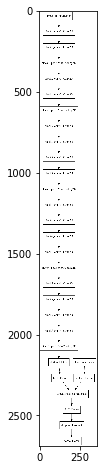

In [10]:
tf.keras.utils.plot_model(
    multi_input_model,
    to_file=model_image_path,
    show_shapes=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96
)

img = mpimg.imread(model_image_path)
plt.imshow(img)

In [11]:
# multi_input_model.summary()

In [12]:
print_layer_trainable(multi_input_model)

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_conv4
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_conv4
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
True:	block5_conv3
True:	block5_conv4
True:	block5_pool
True:	flatten
True:	hier
True:	fc_1
True:	fc_hier
True:	concatenate
True:	fc_2
True:	dropout
True:	dense


In [13]:
multi_input_model.trainable

True

## Create a callback checkpoint 

In [14]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [15]:
history = multi_input_model.fit(dataset_multi_train,
                    epochs=EPOCHS,
                    validation_data=dataset_multi_val,
                    callbacks=[cp_callback,
                               csv_logger,
                               #sanity_check_callback,
                              ])

Epoch 1/30
    417/Unknown - 158s 380ms/step - loss: 0.7453 - accuracy_on_one: 0.8235 - accuracy_on_zero: 0.7915 - precision_on_1: 0.2627
Epoch 00001: saving model to /home/ubuntu/efs/models/Checkpoints/model_Multi_input_sample_size_all_epoch_30_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10.ckpt
417/417 [==============================] - 199s 477ms/step - loss: 0.7453 - accuracy_on_one: 0.8235 - accuracy_on_zero: 0.7915 - precision_on_1: 0.2627 - val_loss: 0.0000e+00 - val_accuracy_on_one: 0.0000e+00 - val_accuracy_on_zero: 0.0000e+00 - val_precision_on_1: 0.0000e+00
Epoch 2/30
416/417 [============================>.] - ETA: 0s - loss: 0.5556 - accuracy_on_one: 0.8775 - accuracy_on_zero: 0.8594 - precision_on_1: 0.3437
Epoch 00002: saving model to /home/ubuntu/efs/models/Checkpoints/model_Multi_input_sample_size_all_epoch_30_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10.ckpt
417/417 [==============================] - 193s 464ms/step - loss: 0.555

Epoch 16/30
416/417 [============================>.] - ETA: 0s - loss: 0.3283 - accuracy_on_one: 0.9434 - accuracy_on_zero: 0.9119 - precision_on_1: 0.4731
Epoch 00016: saving model to /home/ubuntu/efs/models/Checkpoints/model_Multi_input_sample_size_all_epoch_30_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10.ckpt
417/417 [==============================] - 195s 468ms/step - loss: 0.3283 - accuracy_on_one: 0.9434 - accuracy_on_zero: 0.9119 - precision_on_1: 0.4731 - val_loss: 0.3875 - val_accuracy_on_one: 0.8996 - val_accuracy_on_zero: 0.9141 - val_precision_on_1: 0.4671
Epoch 17/30
324/417 [======================>.......] - ETA: 34s - loss: 0.3222 - accuracy_on_one: 0.9456 - accuracy_on_zero: 0.9135 - precision_on_1: 0.4785

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



416/417 [============================>.] - ETA: 0s - loss: 0.2559 - accuracy_on_one: 0.9650 - accuracy_on_zero: 0.9308 - precision_on_1: 0.5389
Epoch 00027: saving model to /home/ubuntu/efs/models/Checkpoints/model_Multi_input_sample_size_all_epoch_30_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10.ckpt
417/417 [==============================] - 194s 465ms/step - loss: 0.2559 - accuracy_on_one: 0.9650 - accuracy_on_zero: 0.9308 - precision_on_1: 0.5389 - val_loss: 0.4004 - val_accuracy_on_one: 0.8787 - val_accuracy_on_zero: 0.9283 - val_precision_on_1: 0.5065
Epoch 28/30
416/417 [============================>.] - ETA: 0s - loss: 0.2506 - accuracy_on_one: 0.9662 - accuracy_on_zero: 0.9322 - precision_on_1: 0.5443
Epoch 00028: saving model to /home/ubuntu/efs/models/Checkpoints/model_Multi_input_sample_size_all_epoch_30_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10.ckpt
417/417 [==============================] - 195s 467ms/step - loss: 0.2506 - accur

## Load old weights?

In [43]:
# Loads the weights from the checkpoint path above
# new_model.load_weights(checkpoint_path)

## Create the datasets (incl. image pre-processing, resizing, putting into batches)

## Save history and model

In [16]:
# Save the training history

pickle.dump(history.history, open(training_history_path, 'wb'))

# Save the model
multi_input_model.save(saved_model_path)

In [19]:
saved_model_path

'/home/ubuntu/efs/models/Saved_models/model_Multi_input_sample_size_15000_epoch_10_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10.h5'